In [39]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# seed 설정
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

# 0 ~ 1사이의 값으로 float32로 변경하는 함수
def get_preprocessed_data(images, labels, scaling=True):
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

# 0 ~ 1사이의 값 float32로 변경하는 함수 호출 후 OHE적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    # OHE적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2023):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

# random seed는 2023으로 고정
set_random_seed(2023)

# 전처리, OHE 적용 후 학습.검증/데이터 세트 생성
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)




(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


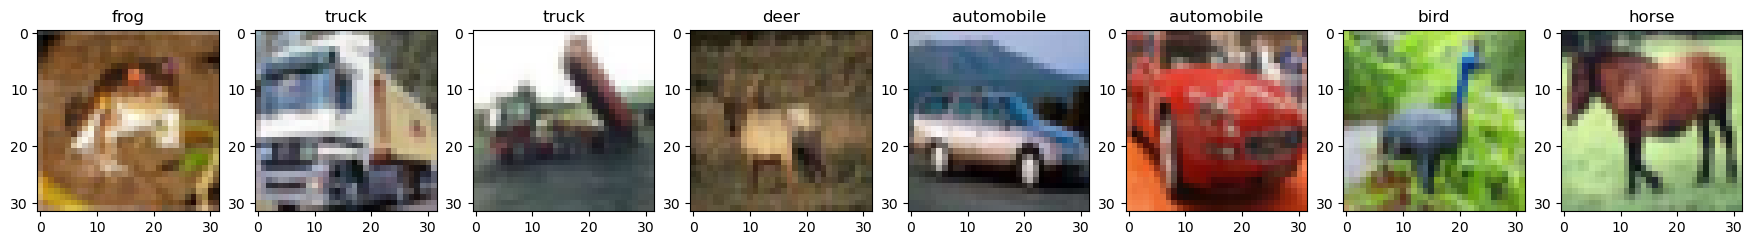

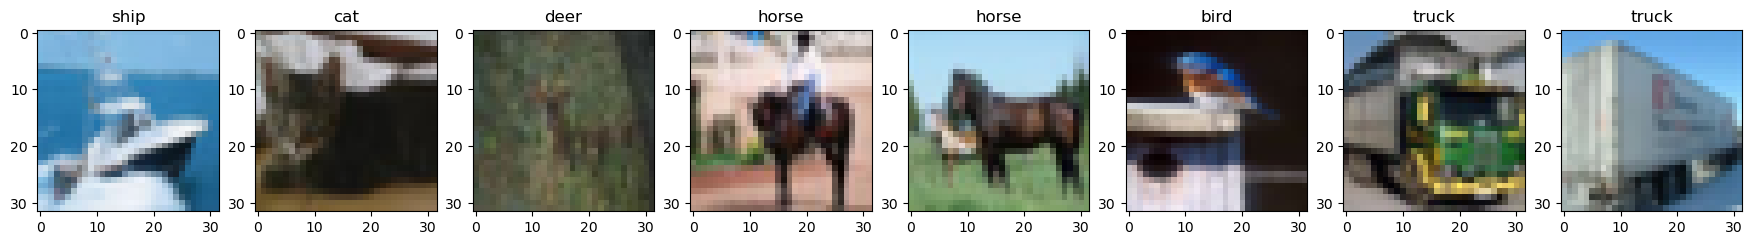

In [40]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)


In [41]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

####  ImageDataGenerator로 Augmentation 설정하고 학습용, 검증용 Generator 생성

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trian_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0) # augmentation하면 안됨

# model.fit()하기 전에, ImageGenerator에서, batch_size설정 후 model로 넘겨주기 위해서
# flow()를 사용
flow_tr_gen = trian_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

#### CNN모델 생성

In [43]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

def create_model(verbose=False):
    clear_session()
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    #x = Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = Activation('relu')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=2)(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Flatten 대신 Global AveragePooling 을 적용. 
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    if verbose:
        model.summary()
        
    return model

In [29]:
model = create_model(verbose=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0     

In [30]:
# flow 에서 batch_size만큼 모델에 들어감
image_batch, label_batch = next(flow_tr_gen)
print(image_batch.shape, label_batch.shape)

(64, 32, 32, 3) (64, 10)


In [36]:
# 원래는, model.fit할 때
'''
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=30, shuffle=True,
                    validation_data=(val_images, val_oh_labels),  
                    callbacks=[rlr_cb, ely_cb] )
'''

# flow_tr_gen(generator)의 리턴값이 image, label이므로, y가 필요없음
tr_data_len = tr_images.shape[0] # 42500개 data
val_data_len = val_images.shape[0]

history = model.fit(
    flow_tr_gen, epochs=40,
    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
    validation_data=flow_val_gen,
    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
    callbacks=[rlr_cb, ely_cb]
)

Epoch 1/40
665/665 [==============================] - 21s 19ms/step - loss: 1.4593 - accuracy: 0.4740 - val_loss: 1.3534 - val_accuracy: 0.5039
Epoch 2/40
665/665 [==============================] - 12s 18ms/step - loss: 1.0107 - accuracy: 0.6446 - val_loss: 1.6876 - val_accuracy: 0.4659
Epoch 3/40
665/665 [==============================] - 12s 19ms/step - loss: 0.8379 - accuracy: 0.7113 - val_loss: 0.9488 - val_accuracy: 0.6805
Epoch 4/40
665/665 [==============================] - 12s 19ms/step - loss: 0.7002 - accuracy: 0.7619 - val_loss: 0.7824 - val_accuracy: 0.7348
Epoch 5/40
665/665 [==============================] - 13s 19ms/step - loss: 0.6145 - accuracy: 0.7936 - val_loss: 1.0357 - val_accuracy: 0.6857
Epoch 6/40
665/665 [==============================] - 13s 19ms/step - loss: 0.5486 - accuracy: 0.8178 - val_loss: 0.5485 - val_accuracy: 0.8151
Epoch 7/40
665/665 [==============================] - 13s 19ms/step - loss: 0.4962 - accuracy: 0.8342 - val_loss: 0.7502 - val_accuracy:

In [37]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 7ms/step - loss: 0.4934 - accuracy: 0.8852


[0.4933825135231018, 0.885200023651123]

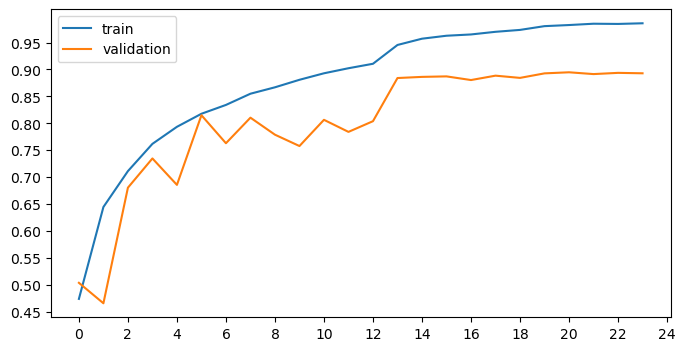

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
show_history(history)